 **IMPORT NECESSARY LIBRARIES**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Masking, LSTM, Add,Input,Activation
from tensorflow.keras.regularizers import  l2
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model,load_model
import itertools    
import time
import random
from collections import defaultdict
import pathlib
from catboost import CatBoostRegressor

import time

In [2]:
## Input Variables 
Survey_variables = ['Income','Gender','Mazda_TV','Mazda_SocialMedia','HowOften_YouTube','HowOften_Facebook',
                    'HowOften_Twitter','AvgTimePerVisit_YouTube','AvgTimePerVisit_Facebook','AvgTimePerVisit_Twitter',
                    'set_Final_segment','CurrentVehicleBrand','HowSoonLikelyToBuyNewVehicle','NextVehicleType_Midsize',
                    'NextVehicleType_Fullsize','NewVehicle_ImpFactors_ValueForMoney','NewVehicle_ImpFactors_Brand',
                    'NewVehicle_ImpFactors_FuelEfficiency','NewVehicle_ImpFactors_Safety','NewVehicle_ImpFactors_VehicleStyle',
                    'NewVehicle_ImpFactors_Handling','Have_Owned_Mazda_Ever']

Exposure_variables = ['DeviceType', 'Browser','OS', 'Publisher', 'Audience', 'CreativeFormat', 'CreativeTheme',
                      'CreativeSize']

#### READING EXPOSURE/SURVEY DATA AND OUTPUT PATH

In [3]:
#input exposure and survey data
exposure_df=pd.read_csv("Processed_Exposure_data_v2.csv",encoding="ISO-8859-1")
survey_df=pd.read_csv("Processed_Survey_data.csv",encoding="ISO-8859-1")

#input parameters file
parameters_file=pd.read_csv("Parameters_file_07_05_2021.csv")

#Assigning output paths
dv_folder=parameters_file[parameters_file.Variable=='Modeling_output_folder']['Value'].reset_index(drop=True)[0]+"/"
EDA_file_path=parameters_file[parameters_file.Variable=='EDA_folder']['Value'].reset_index(drop=True)[0]+"/"

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (122,123,124,125,126,127,128,129,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Creating folders to save results. If this breaks,create manually

folders=np.array([EDA_file_path,'simulation','simulation/tv_simulation','simulation/tv_simulation/no_tv','simulation/tv_simulation/3D_simulation','simulation/adchar/','simulation/adchar/all_exposure/'
'simulation/adchar/final_adchar_exposure_level_pred','simulation/adchar/final_adchar_exposure_level_pred_mean','simulation/adchar/final_adchar_user_level_pred','simulation/adchar/final_adchar_user_level_pred_mean','simulation/adchar/no_tv',
'prediction','prediction/control_user_prediction','prediction/demographic','prediction/one_pred_per_exposure','prediction/one_pred_per_user',
'LSTM','LSTM/CSV_logger','curves','curves/Adchar_simulation','curves/Adchar_simulation/no_tv','curves/demographic','curves/final','lifts','lifts/first_exposure','lifts/demo_first_exposure','lifts/CME','var_imp'])

for fpath in folders:                 
    pathlib.Path(dv_folder + fpath).mkdir(parents=True, exist_ok=True) 

In [5]:
# setting the seed (ignore if any of these throws an error )
np.random.seed(int(parameters_file[parameters_file.Variable=='Numpy seed']['Value'].reset_index(drop=True)[0]))
random.seed(int(parameters_file[parameters_file.Variable=='Python seed']['Value'].reset_index(drop=True)[0]))
tf.random.set_seed(int(parameters_file[parameters_file.Variable=='Tensorflow seed']['Value'].reset_index(drop=True)[0]))

# BLOCK 1 - DATA PREPROCESSING AND EDA

#### INDEPENDENT AND DEPENDENT VARIABLES

In [6]:
#DV variables
dv=parameters_file[parameters_file.Variable=='DV_modeling']['Value'].reset_index(drop=True)[0]

#Saving other variables used for modeling in a dictionary
d={}
other_dv_num=len(parameters_file[parameters_file.Variable=='Other DVs']['Value'])
for i in range(other_dv_num):
   d['dv'+str(i+1)]=parameters_file[parameters_file.Variable=='Other DVs']['Value'].reset_index(drop=True)[i]


#survey and exposure variables
survey_cols=['ID','cell',dv,d['dv1'],d['dv2'],d['dv3']] + Survey_variables
exposure_columns=['ID', 'HitDate','IED'] + Exposure_variables
survey_df2=survey_df[survey_cols]


#### CREATING INTER EXPOSURE DURATION(IED) 

In [7]:
exposure_df['HitDate_tmp']=pd.to_datetime(exposure_df['HitDate'])
exposure_df.drop(columns=['HitDate'],inplace=True)
exposure_df.rename(columns={'HitDate_tmp':'HitDate'},inplace=True)
exposure_df=exposure_df.sort_values(['Dwid','HitDate']).reset_index(drop=True)
exposure_df['HitDate_lag'] = exposure_df.groupby('Dwid')['HitDate'].shift()
exposure_df['IED'] = exposure_df['HitDate'] - exposure_df['HitDate_lag']
exposure_df['IED'] = exposure_df['IED'].astype('timedelta64[s]')
exposure_df['IED'].fillna(0,inplace=True)
exposure_df.drop(columns=['HitDate_lag'],inplace=True)



#### RENAMING

In [8]:
exposure_df.rename(columns={"Creative_Format":"CreativeFormat","Creative_Theme":"CreativeTheme","Creative_Size":"CreativeSize"},inplace=True)
exposure_df.rename(columns={'Respondentid':'ID'},inplace=True)

In [9]:
exp_count=exposure_df.groupby('ID').size().values
exp_count_distribution=np.percentile(exp_count,np.array([0,10,20,30,40,50,60,70,80,90,95,97,98,99,100]))
Distribution=pd.DataFrame()
Distribution['Percentile']=np.array([0,10,20,30,40,50,60,70,80,90,95,97,98,99,100])
Distribution['Value']= exp_count_distribution                                  
print("Exposure count distribution before deduplication :")
print (Distribution.to_string(index=False))

Exposure count distribution before deduplication :
 Percentile    Value
          0     1.00
         10     1.00
         20     2.00
         30     3.00
         40     5.00
         50     7.00
         60    11.00
         70    17.00
         80    30.00
         90    60.70
         95   103.85
         97   156.00
         98   186.74
         99   259.70
        100  2077.00


#### EXTRACTING TEST AND CONTROL IDs

In [10]:
control_ids=survey_df2[survey_df2['cell']=='control'].ID.values
test_ids2=survey_df2[survey_df2['cell']=='test'].ID.values
print("Number of test users in survey data : " ,len(test_ids2) )
test_ids=set(test_ids2) & set(exposure_df['ID'].values)
print("Number of users in exposure data : ",len(exposure_df['ID'].unique()))
print("Number of users common in survey and exposure data : ",len(test_ids) )
print("Number of control users :",len(control_ids))
model_ids=np.concatenate([np.array(list(test_ids)),np.array(list(control_ids))])
print("Total users :",len(model_ids))
survey_df2=survey_df2[survey_df2.ID.isin(model_ids)]
exposure_df=exposure_df[exposure_df.ID.isin(test_ids)]

Number of test users in survey data :  1767
Number of users in exposure data :  1764
Number of users common in survey and exposure data :  1764
Number of control users : 1979
Total users : 3743


#### FINDING VARIABLE LEVEL PROPORTION - BEFORE ROLLUP - TO CREATE ROLLUP FILE

###### *Output File name:exposure_variable_proportions_before_rollup.csv | Output path:EDA*

In [11]:
exposure_variables=[var for var in exposure_columns if var not in ('ID', 'HitDate','IED')]
totalDetails=[]

for var_ind,var in enumerate(exposure_variables):
    exposure_df[var].replace(np.nan,'Missing',inplace=True)
    val_count=exposure_df[var].value_counts(dropna=False,normalize=True)
    for level in range(len(val_count)):
        fileDetails={}
        fileDetails['variable']=var
        fileDetails['level']=val_count.index[level]
        fileDetails['proportion']=val_count[val_count.index[level]]
        totalDetails.append(fileDetails)
exposure_variable_proportions=pd.DataFrame(totalDetails)

exposure_variable_proportions=exposure_variable_proportions.groupby(['variable'], sort=False).apply(lambda x: x.sort_values(['level'], ascending=True))
exposure_variable_proportions.to_csv(dv_folder+EDA_file_path+'exposure_variable_proportions_before_rollup.csv',index=False)
del totalDetails,exposure_variable_proportions

In [12]:
survey_variables=[var for var in survey_cols if var not in ('ID','cell')]
totalDetails=[]

for var_ind,var in enumerate(survey_variables):
    survey_df2[var].replace(np.nan,'Missing',inplace=True)
    val_count=survey_df2[var].value_counts(dropna=False,normalize=True)
    for level in range(len(val_count)):
        fileDetails={}
        fileDetails['variable']=var
        fileDetails['level']=val_count.index[level]
        fileDetails['proportion']=val_count[val_count.index[level]]
        totalDetails.append(fileDetails)
survey_variable_proportions=pd.DataFrame(totalDetails)
survey_variable_proportions=survey_variable_proportions.groupby(['variable'], sort=False).apply(lambda x: x.sort_values(['level'], ascending=True))
survey_variable_proportions.to_csv(dv_folder+EDA_file_path+'survey_variable_proportions_before_rollup.csv',index=False)
del totalDetails,survey_variable_proportions

#### ROLLING UP SURVEY AND EXPOSURE DATA

#### user has to copy/paste the files 'exposure_variable_proportions_before_rollup.csv' and 'survey_variable_proportions_before_rollup.csv' to different names 'exposure_mapping_rollup.csv' and 'survey_mapping_rollup.csv' respectively and add the newLevel column.

In [13]:
#Input files - Reading excel file with new mapping

#level_mapping_survey=pd.read_csv( dv_folder+EDA_file_path+'survey_mapping_rollup.csv')
#level_mapping_exposure=pd.read_csv(dv_folder+EDA_file_path+'exposure_mapping_rollup.csv')

level_mapping_survey=pd.read_csv( 'survey_mapping_rollup.csv')
level_mapping_exposure=pd.read_csv('exposure_mapping_rollup.csv')

In [14]:
#Finding the numeric variable in survey data as they should be treated differently in next step
survey_numeric=survey_df2._get_numeric_data()
num_variable=[var for var in survey_numeric.columns if var not in ('ID')]

In [15]:
#survey data rollup

for var_ind,var in enumerate(level_mapping_survey.variable.unique()):
    survey_df2[var].replace(np.nan,'Missing',inplace=True)
    df_rollup=level_mapping_survey[level_mapping_survey['variable']==var]
    dict_rollup=dict(zip(df_rollup.level, df_rollup.newlevel))
    if var in num_variable:    
        output_dict = {}
        for key, value in dict_rollup.items():
            output_dict[int(key)] = value
        survey_df2[var].replace(output_dict,inplace=True)
    else:
        survey_df2[var].replace(dict_rollup,inplace=True)

survey_df2=survey_df2.astype({'NextVehicleType_Midsize':'int','NextVehicleType_Fullsize':'int','NewVehicle_ImpFactors_ValueForMoney':'int','NewVehicle_ImpFactors_Brand':'int', 'NewVehicle_ImpFactors_FuelEfficiency':'int', 'NewVehicle_ImpFactors_Safety':'int','NewVehicle_ImpFactors_VehicleStyle':'int','NewVehicle_ImpFactors_Handling':'int', 'Mazda_SocialMedia':'int','Mazda_TV':'int','AgreeDisagree_Mazda_premium':'int','LikelyToBuyLease_Mazda': 'int','FamiliarityWith_Mazda':'int','OverallOpinion_Mazda':'int'})


In [16]:
# exposure data rollup

for var_ind,var in enumerate(level_mapping_exposure.variable.unique()):
    exposure_df[var].replace(np.nan,'Missing',inplace=True)
    df_rollup=level_mapping_exposure[level_mapping_exposure['variable']==var]
    dict_rollup=dict(zip(df_rollup.level, df_rollup.newlevel))
    exposure_df[var].replace(dict_rollup,inplace=True)

#### Handling Missings by Imputation

In [17]:
#TV_data_available=int(parameters_file[parameters_file.Variable=='TV_data_available']['Value'].reset_index(drop=True)[0])
#if(TV_data_available):
    #survey_df2['TV_Exposed'].replace(-1,0,inplace=True)
    #survey_df2['TV_Exposed'].fillna(0,inplace=True)

## EDA

#### FINDING VARIABLE LEVEL PROPORTIONS - AFTER ROLLLUP

##### *Output File name:exposure_variable_proportions.csv,survey_variable_proportions.csv | Output path: EDA*

In [18]:
exposure_variables=[var for var in exposure_columns if var not in ('ID', 'HitDate','IED')]
totalDetails=[]

for var_ind,var in enumerate(exposure_variables):
    exposure_df[var].replace(np.nan,'Missing',inplace=True)
    val_count=exposure_df[var].value_counts(dropna=False,normalize=True)
    val_count_abs=exposure_df[var].value_counts(dropna=False)
    for level in range(len(val_count)):
        fileDetails={}
        fileDetails['variable']=var
        fileDetails['level']=val_count.index[level]
        fileDetails['proportion']=val_count[val_count.index[level]]
        fileDetails['Records']=val_count_abs[val_count_abs.index[level]]
        totalDetails.append(fileDetails)
exposure_variable_proportions=pd.DataFrame(totalDetails)
exposure_variable_proportions=exposure_variable_proportions.groupby(['variable'], sort=False).apply(lambda x: x.sort_values(['level'], ascending=True))
exposure_variable_proportions.to_csv(dv_folder+EDA_file_path+'exposure_variable_proportions.csv',index=False)
del totalDetails


survey_variables=[var for var in survey_cols if var not in ('ID','cell')]
totalDetails=[]

for var_ind,var in enumerate(survey_variables):
    survey_df2[var].replace(np.nan,'Missing',inplace=True)
    val_count=survey_df2[var].value_counts(dropna=False,normalize=True)
    val_count_abs=survey_df2[var].value_counts(dropna=False)
    for level in range(len(val_count)):
        fileDetails={}
        fileDetails['variable']=var
        fileDetails['level']=val_count.index[level]
        fileDetails['proportion']=val_count[val_count.index[level]]
        fileDetails['Records']=val_count_abs[val_count_abs.index[level]]
        totalDetails.append(fileDetails)
survey_variable_proportions=pd.DataFrame(totalDetails)
survey_variable_proportions=survey_variable_proportions.groupby(['variable'], sort=False).apply(lambda x: x.sort_values(['level'], ascending=True))
survey_variable_proportions.to_csv(dv_folder+EDA_file_path+'survey_variable_proportions.csv',index=False)
del totalDetails


#### FINDING T2B AVERAGE FOR TEST AND CONTROL USERS

##### *Output File name:DV_mean_Control_Test.csv | Output path: EDA*

In [19]:
totalDetails=[]
dvs=[dv,d['dv1'],d['dv2'],d['dv3']]
for qind,q in enumerate(dvs):
    fileDetails={}
    fileDetails['dv']=q
    fileDetails['control_T2B']=survey_df2[survey_df2['cell']=='control'][q].mean()
    fileDetails['test_T2B']=survey_df2[survey_df2['cell']=='test'][q].mean()
    totalDetails.append(fileDetails)
t2b=pd.DataFrame(totalDetails)
t2b.to_csv(dv_folder+EDA_file_path+'DV_mean_Control_Test.csv',index=False)
del totalDetails

#### FINDING T2B AVERAGE BY VARIABLES

##### *Output File name:DV_mean_Control_Test_variable.csv | Output path: EDA*

In [20]:
#Input variables

totalDetails=[]
variables= Survey_variables
dvs=[dv,d['dv1'],d['dv2'],d['dv3']]
for qind,q in enumerate(dvs):
    for var_ind,var in enumerate(variables):
        df_mean=survey_df2.groupby([var,'cell'])[q].mean()
        for k in range(len(df_mean)):
            fileDetails={}
            fileDetails['level']=df_mean.index[k][0]
            fileDetails['user_type']=df_mean.index[k][1]
            fileDetails['T2B']=df_mean[df_mean.index[k]]
            fileDetails['dv']=q
            fileDetails['variable']=variables[var_ind]
            fileDetails['proportion']=survey_variable_proportions[(survey_variable_proportions['variable']==var) & (survey_variable_proportions['level']==df_mean.index[k][0])]['proportion'].values[0]
            fileDetails['Records']=survey_variable_proportions[(survey_variable_proportions['variable']==var) & (survey_variable_proportions['level']==df_mean.index[k][0])]['Records'].values[0]
            totalDetails.append(fileDetails)
        del df_mean
variable_t2b=pd.DataFrame(totalDetails)
variable_t2b=variable_t2b.pivot_table('T2B', ['dv','variable','level','proportion','Records'], 'user_type')
#variable_t2b=variable_t2b.rename(columns={'control':'control_mean_of_dv','test':'test_mean_of_dv'})
variable_t2b.to_csv(dv_folder+EDA_file_path+'DV_mean_Control_Test_variable.csv')
#print(variable_t2b)
del totalDetails


# BLOCK 2 - DATA PREPERATION FOR MODELING

#### DROPPING DUPLICATE EXPOSURES AND DVs WHICH ARE NOT USED IN MODELING

In [21]:
start_time_VI = time.time()
print(start_time_VI)

1645705295.7396162


In [22]:
exposure_df2=exposure_df[exposure_columns]
print("No of records before removing duplicates", len(exposure_df2))
exposure_columns2=['ID', 'HitDate'] + Exposure_variables
exposure_df2.drop_duplicates(subset=exposure_columns2,inplace=True)
print("No of records after removing duplicates", len(exposure_df2))

survey_df2.drop(columns=[d['dv1'],d['dv2'],d['dv3']],inplace=True)

No of records before removing duplicates 45107
No of records after removing duplicates 37273


<ipython-input-22-314e7cd7bf0d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposure_df2.drop_duplicates(subset=exposure_columns2,inplace=True)


In [23]:
exp_count=exposure_df2.groupby('ID').size().values
exp_count_distribution=np.percentile(exp_count,np.array([0,10,20,30,40,50,60,70,80,90,95,97,98,99,100]))
Distribution=pd.DataFrame()
Distribution['Percentile']=np.array([0,10,20,30,40,50,60,70,80,90,95,97,98,99,100])
Distribution['Value']= exp_count_distribution                                  
print("Exposure count distribution after deduplication :")
print (Distribution.to_string(index=False))
print("Use this distribution to set the max_seq length")

Exposure count distribution after deduplication :
 Percentile    Value
          0     1.00
         10     1.00
         20     2.00
         30     3.00
         40     4.00
         50     6.00
         60    10.00
         70    15.00
         80    27.00
         90    50.00
         95    88.85
         97   129.11
         98   156.48
         99   206.11
        100  1310.00
Use this distribution to set the max_seq length


#### MERGING SURVEY DATA TO EXPOSURE DATA

In [24]:
exposure_df2_org=exposure_df2.copy()
survey_df2_org=survey_df2.copy()
exposure_df22=pd.merge(exposure_df2, survey_df2, on=['ID'])
survey_df22=survey_df2[survey_df2['cell']=='control']

#### ADDING SURVEY RECORD FOR EVERY USER

In [25]:
def add_survey(data,is_control_user):
    if is_control_user==0:        
        survey_record = data.iloc[-1]
    else:
        survey_record = data
    
    variables= Exposure_variables
    for var in variables:
        survey_record[var]='Survey'
    survey_record['IED'] = 0
    
    if is_control_user==0:
        data2=data.sort_values('HitDate')
        data2=data2.append(survey_record)
        data2.drop(columns=['HitDate'],inplace=True)
        data2['Exposnum'] = np.arange(len(data2))
        del data
        return data2
    else:
        survey_record['Exposnum'] = 0
        return survey_record

data_by_user = exposure_df22.groupby(by='ID', as_index=False)
exposure_df3 = data_by_user.apply(lambda x: add_survey(x,0))

del data_by_user

data_by_user = survey_df22.groupby(by='ID', as_index=False)
survey_df3 = data_by_user.apply(lambda x: add_survey(x,1))

del data_by_user


#### STACKING CONTROL AND TEST USER RECORDS

In [26]:
totaldf=pd.concat([exposure_df3,survey_df3])

In [27]:
#### COLLAPSE EXPOSURES-METHOD 1)Drop all users with more than Max_seq exposure 2)consider the latest Max_seq number of exposures 


In [28]:
#Inputting collapse method and Max_seq to be used

collapse_exposures_method=int(parameters_file[parameters_file.Variable=='collapse_exposures_method']['Value'].reset_index(drop=True)[0])
max_seq=int(parameters_file[parameters_file.Variable=='Max_seq']['Value'].reset_index(drop=True)[0])

print("The collapse method selected is : ",collapse_exposures_method)
print("The maximum sequence length selected is : ",max_seq)

if(collapse_exposures_method==2):    
    totaldf=totaldf.sort_values(['ID','Exposnum']).groupby('ID').tail(max_seq)
    exposure_df2_org=exposure_df2_org.sort_values(['ID','HitDate']).groupby('ID').tail(max_seq-1)
    testids_to_model=test_ids
if(collapse_exposures_method==1):
    mta_df=totaldf.groupby('ID')['Exposnum'].max()
    exclude_uids=mta_df[mta_df>max_seq].index
    test_ids2=np.array(list(test_ids))
    testids_to_model=test_ids2[~np.isin(test_ids2,exclude_uids)]
    model_ids=np.concatenate([testids_to_model,np.array(list(control_ids))])

The collapse method selected is :  2
The maximum sequence length selected is :  100


In [29]:
# For optimizer: Create dataset to be used in Stage 2


In [30]:
totaldf.drop('Exposnum',axis=1,inplace=True)
totaldf['Exposnum']=totaldf.groupby('ID').cumcount()
totaldf['Exposnum']=totaldf['Exposnum']+1
totaldf.to_csv('mazdauf_noOHE.csv')

#### ONE HOT ENCODING

In [31]:
#finding categorical variables except for 'cell' variable to one hot encode
numeric_var=totaldf._get_numeric_data()
categoric_var=list(set(totaldf.columns)-set(numeric_var))
dummycols=[var for var in categoric_var if var not in ['cell'] ]
    
finaldf = pd.get_dummies(totaldf,columns=dummycols)

#This variable is used later while plotting Adchar curves
finaldf_adchar=finaldf.columns


In [32]:
# For optimizer: Create OHE raw data to be used in Stage 0
finaldf.to_csv('OHE_raw_data.csv')

In [33]:
#Removing one dummy level after one hot encoding
var_to_remove=[]

for var in dummycols:
    if 'Missing' in totaldf[var].unique():
        missing_var=var+'_Missing'
        var_to_remove.append(missing_var)
    elif 'Others' in totaldf[var].unique():
        Others_var=var+'_Others'
        var_to_remove.append(Others_var)
    else :
        variable=var+'_'+[col for col in totaldf[var].unique() if col not in ['Survey']][0]
        var_to_remove.append(variable)


finaldf=finaldf.drop(var_to_remove,axis = 1)
finaldf = finaldf.reindex(sorted(finaldf.columns), axis=1)
finaldf2=finaldf.copy()
print(finaldf.shape)

(33848, 187)


In [34]:
#### SELECTING VARIABLES TO BE USED FOR MODELING  ############
model_vars=[]
model_vars=finaldf.columns
vars_to_drop=['ID','Exposnum','cell',dv,'TV_Exposed']
model_vars=model_vars[~np.isin(model_vars,vars_to_drop)]
pd.DataFrame(model_vars,columns={'vars'}).to_csv(dv_folder + 'digital_input_vars_to_model.csv')

############### when these models are use used for prediction in future use these columns order in get_padded_data ##############

#### DEFINING EVALUATION METRICS

In [35]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#### GET SEQUENCES(INPUT TO LSTM MODEL)

In [36]:
def get_padded_data(jobids):
    data1 = []
    Y = []
    TV=[]
    jobid = []

    for ID_ind,ID in enumerate(jobids):
        df=finaldf[finaldf['ID']==ID].sort_values('Exposnum').reset_index(drop=True)
        if (collapse_exposures_method==2):
            df.loc[0,'IED']=0
        df['IED']=df['IED'].apply(lambda x:np.log(x+1))
        y=df[dv].values[0]
        #if(TV_data_available):
            #tv=df['TV_Exposed'].values[0]
            #TV.append(tv)
        df=df[model_vars]
        #df.drop(columns=['ID','Exposnum','cell',dv,'TV_Exposed'],inplace=True)
        data1.append(np.array(df))
        Y.append(y)
        jobid.append(ID)
        del df
    Y = np.array(Y)  
    X = pad_sequences(data1, dtype='float32',maxlen=max_seq,value=-1)
    #if(TV_data_available):
        #tv = np.array(TV)
        #return X,Y,jobid,tv
    #else:
    return X,Y,jobid
        

# BLOCK 3 - MODELING

#### MODELING CONFIGURATIONS - ( No of Bootsrap models, Train-Val split)

In [37]:
#Inputting training split
training_split=int(parameters_file[parameters_file.Variable=='Train_Split_percentage']['Value'].reset_index(drop=True)[0])
training_num=int(len(model_ids)*training_split*0.01)

#inputting number of bootstrap models
######## incremental bootstrap and IED in above block, set the seed for replicability
total_models=int(parameters_file[parameters_file.Variable=='Bootstrap_models']['Value'].reset_index(drop=True)[0])

#### MODELING HYPERPARAMETERS

In [38]:
#inputting all the hyperparameters from input file

batchSize=int(parameters_file[parameters_file.Variable=='batchSize']['Value'].reset_index(drop=True)[0])
max_epochs=int(parameters_file[parameters_file.Variable=='max_epochs']['Value'].reset_index(drop=True)[0])
early_stop_patience=int(parameters_file[parameters_file.Variable=='early_stop_patience']['Value'].reset_index(drop=True)[0])
lstm_hidden_state_size=int(parameters_file[parameters_file.Variable=='lstm_hidden_state_size']['Value'].reset_index(drop=True)[0])
lstm_input_dropout=float(parameters_file[parameters_file.Variable=='lstm_input_dropout']['Value'].reset_index(drop=True)[0])
dense_dropout=float(parameters_file[parameters_file.Variable=='dense_dropout']['Value'].reset_index(drop=True)[0])

kernel_regularization_factor=float(parameters_file[parameters_file.Variable=='kernel_regularization_factor']['Value'].reset_index(drop=True)[0])
recurrent_kernel_regularization_factor=float(parameters_file[parameters_file.Variable=='recurrent_kernel_regularization_factor']['Value'].reset_index(drop=True)[0])
bias_regularization_factor=float(parameters_file[parameters_file.Variable=='bias_regularization_factor']['Value'].reset_index(drop=True)[0])
initial_learning_rate=float(parameters_file[parameters_file.Variable=='initial_learning_rate']['Value'].reset_index(drop=True)[0])
earlystop_by_val_acc=int(parameters_file[parameters_file.Variable=='earlystop_by_val_acc']['Value'].reset_index(drop=True)[0])
earlystop_by_val_loss=int(parameters_file[parameters_file.Variable=='earlystop_by_val_loss']['Value'].reset_index(drop=True)[0])

tv_dropout=float(parameters_file[parameters_file.Variable=='tv_dropout']['Value'].reset_index(drop=True)[0])
try_tv_dropout=float(parameters_file[parameters_file.Variable=='try_tv_dropout']['Value'].reset_index(drop=True)[0])


#### TRAINING LSTM NETWORK

##### *Output Files:model objects(.h5) | Output path: LSTM*

In [39]:

for model_num in range(total_models):
    random.shuffle(model_ids)
    #if(TV_data_available):
        #X,Y,jobid,tv=get_padded_data(model_ids)
    #else:
    X,Y,jobid=get_padded_data(model_ids)     
    
    print(X.shape)
    
    pd.DataFrame(jobid[training_num:],columns={'ID'}).to_csv(dv_folder +'LSTM/'+'model_'+str(model_num) + '_testIDs.csv',index=None)

    sess=tf.compat.v1.Session() 
    K.set_session(sess)
    
    Inp = Input(shape=(None, X.shape[-1]),name='features')
                
    #if(TV_data_available):
        #Inptv = Input(shape=(1,),name='tvfeatures')      
        
    x1=Masking(mask_value=-1)(Inp)
    x1=LSTM(lstm_hidden_state_size, dropout=lstm_input_dropout,kernel_initializer='glorot_normal',  recurrent_initializer='glorot_normal', kernel_regularizer=l2(kernel_regularization_factor), recurrent_regularizer=l2(recurrent_kernel_regularization_factor),bias_regularizer=l2(bias_regularization_factor),return_sequences=False)(x1)
    x2=Dropout(dense_dropout)(x1)
    x2=Dense(1,kernel_regularizer=l2(kernel_regularization_factor),  bias_regularizer=l2(bias_regularization_factor))(x2)

    #if(TV_data_available):
        #if(try_tv_dropout):
            #t1=Dropout(tv_dropout)(Inptv)
            #t1=Dense(1,activation='sigmoid',kernel_regularizer=l2(kernel_regularization_factor),  bias_regularizer=l2(bias_regularization_factor),kernel_initializer=tf.keras.initializers.Ones())(t1)
        #else:
            #t1=Dense(1,activation='sigmoid',kernel_regularizer=l2(kernel_regularization_factor),  bias_regularizer=l2(bias_regularization_factor),kernel_initializer=tf.keras.initializers.Ones())(Inptv)
                
        #x2_t1=Add()([t1,x2])
        #x2_t1=Activation('sigmoid',name='loss')(x2_t1)
        #model = Model(inputs=[Inp,Inptv], outputs=[x2_t1])
    #else:
    x3=Activation('sigmoid',name='loss')(x2)
    model = Model(inputs=[Inp], outputs=[x3])

    model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=initial_learning_rate), metrics=['accuracy',f1])
    print(model.summary())

    filepath=dv_folder + 'LSTM/'+ 'model_' + dv +str(model_num) + '.h5'

    if(earlystop_by_val_acc):
        checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')
        early_stop = EarlyStopping(monitor='val_accuracy',mode='max', patience=early_stop_patience)
    elif(earlystop_by_val_loss):
        early_stop = EarlyStopping(monitor='val_loss',mode='min', patience=early_stop_patience)
        checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='min')


    csv_logger = CSVLogger(dv_folder+'LSTM/'+'CSV_logger/' +dv+ str(model_num) + '_training.csv')
    #if(TV_data_available):
        #model.fit({ 'features': X[0:training_num],'tvfeatures': tv[0:training_num]},{'loss': Y[0:training_num]},batch_size=batchSize,epochs=max_epochs,
         #         validation_data=({'features': X[training_num:],'tvfeatures': tv[training_num:]}, {'loss': Y[training_num:]}),callbacks=[checkpoint,csv_logger,early_stop])
        #del X,Y,jobid,tv
    #else:
    model.fit({ 'features': X[0:training_num]},{'loss': Y[0:training_num]},batch_size=batchSize,epochs=max_epochs,validation_data=({'features': X[training_num:]}, {'loss': Y[training_num:]}),
                  callbacks=[checkpoint,csv_logger,early_stop])
    del X,Y,jobid

    sess = K.get_session()
    K.clear_session()
    sess.close()    

(3743, 100, 183)


C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________


Epoch 00028: val_loss did not improve from 0.60722
Epoch 29/150
47/47 [==============================] - 3s 70ms/step - loss: 0.5136 - accuracy: 0.7605 - f1: 0.6884 - val_loss: 0.6984 - val_accuracy: 0.7116 - val_f1: 0.6014

Epoch 00029: val_loss did not improve from 0.60722
Epoch 30/150
47/47 [==============================] - 3s 66ms/step - loss: 0.5160 - accuracy: 0.7725 - f1: 0.7019 - val_loss: 0.6953 - val_accuracy: 0.7063 - val_f1: 0.6014

Epoch 00030: val_loss did not improve from 0.60722
Epoch 31/150
47/47 [==============================] - 3s 67ms/step - loss: 0.5172 - accuracy: 0.7709 - f1: 0.7004 - val_loss: 0.7237 - val_accuracy: 0.7009 - val_f1: 0.5466

Epoch 00031: val_loss did not improve from 0.60722
Epoch 32/150
47/47 [==============================] - 3s 67ms/step - loss: 0.5169 - accuracy: 0.7739 - f1: 0.6974 - val_loss: 0.7071 - val_accuracy: 0.6929 - val_f1: 0.5901

Epoch 00032: val_loss did not improve from 0.60722
Epoch 33/150
47/47 [============================

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

47/47 [==============================] - 3s 74ms/step - loss: 0.5186 - accuracy: 0.7629 - f1: 0.6903 - val_loss: 0.6496 - val_accuracy: 0.7009 - val_f1: 0.5614

Epoch 00028: val_loss did not improve from 0.59408
Epoch 29/150
47/47 [==============================] - 4s 75ms/step - loss: 0.5281 - accuracy: 0.7615 - f1: 0.6737 - val_loss: 0.6513 - val_accuracy: 0.7063 - val_f1: 0.6008

Epoch 00029: val_loss did not improve from 0.59408
(3743, 100, 183)


C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

C:\Users\Sai.Praneeth\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, None, 183)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 183)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                27648     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
loss (Activation)            (None, 1)                 0         
Total params: 27,681
Trainable params: 27,681
Non-trainable params: 0
_________________________________________________________

#### LOADING SAVED MODELS AFTER TRAINING

In [40]:
model_objects={}

for model_num in range(total_models):
    model_objects[model_num]=load_model(dv_folder+'LSTM/'+ 'model_'+ dv  + str(model_num) + '.h5', custom_objects={'f1': f1})


# BLOCK 4 - MODEL PREDICTIONS 

#### Making one prediction for a user after all exposures and aggregate across bootstraps for out-of-bag samples

##### *Output File: one_pred_per_user_outofbag.csv | Output path: prediction/*

In [41]:

#if(TV_data_available):
 #   X,Y,jobid,tv=get_padded_data(model_ids)
#else:
X,Y,jobid=get_padded_data(model_ids)
test_numsec = (X.sum(axis=2) != -X.shape[-1]).sum(axis=1)
    
for model_num in range(total_models):
    df = pd.DataFrame()
    #if(TV_data_available):
     #   outp=model_objects[model_num].predict({'features': X,'tvfeatures': tv},batch_size=2048)
      #  df['tv_exposures']=tv
    #else:
    outp=model_objects[model_num].predict({'features': X},batch_size=2048)
    df['pred' ] = outp.flatten()
    df['ID']= jobid
    df['true' ] = Y  
    df['digi_exp_count']=test_numsec-1
    df.to_csv( dv_folder +'prediction/'+'one_pred_per_user/finalpred_' + str(model_num) + '.csv',index=None)
    del df
#if(TV_data_available):
 #   del X,Y,jobid,tv
#else:
del X,Y,jobid
    

oob_dict = defaultdict(list)

for model_num in range(total_models):
    df=pd.read_csv(dv_folder +'LSTM/'+'model_'+str(model_num) + '_testIDs.csv')
    for ii,gg in enumerate(df.ID.values):
        oob_dict[gg].append(model_num)
    del df
dfs ={}
for model_num in range(total_models):
    df=pd.read_csv(dv_folder +'prediction/'+'one_pred_per_user/finalpred_'+ str(model_num) + '.csv')
    dfs[model_num]=df

count=0
for key in oob_dict:   
    for vv ,gg in enumerate(oob_dict[key]):
        df=dfs[gg]
        if vv==0:
            df1=df[df.ID==key]
        else:
            df1=pd.concat([df1,df[df.ID==key]])
    if count==0:
        df2=df1.mean().to_frame().T
    else:
        df2=pd.concat([df2,df1.mean().to_frame().T])
    del df1,df
    count=count+1
df2.to_csv( dv_folder + 'prediction/'+'one_pred_per_user_outofbag'  + '.csv',index=None)

del dfs,df2,oob_dict            

#### Analysing the model fit


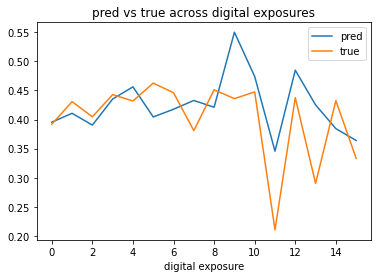

In [42]:
# Analysing the model fit
one_pred_user_oob=pd.read_csv( dv_folder + 'prediction/'+'one_pred_per_user_outofbag'  + '.csv')
df_plot2=one_pred_user_oob.groupby('digi_exp_count').mean()[['pred','true']]
df_plot=pd.DataFrame(df_plot2)
digi_exp_count_cut_off=15
df_plot=df_plot[:digi_exp_count_cut_off]
plt.plot(df_plot)
plt.legend(df_plot.columns)
plt.xlabel('digital exposure')
plt.title('pred vs true across digital exposures')
del one_pred_user_oob ,df_plot2,df_plot

#### PREDICTING AFTER EVERY EXPOSURE FOR EVERY EXPOSED USER USING ALL  BOOTSTRAP MODELS 

##### *Output File : exposers_modelnum.csv | Output path: prediction/one_pred_per_exposure/*

In [43]:
dfs={}
#if(TV_data_available):
 #   X,Y,jobid,tv=get_padded_data(testids_to_model)
#else:
X,Y,jobid=get_padded_data(testids_to_model)
    
print(X.shape)
test_numsec = (X.sum(axis=2) != -X.shape[-1]).sum(axis=1)
#print(np.min(test_numsec), np.max(test_numsec))
list_of_arrays = []
list_of_arrays2 = []
mlen=np.max(test_numsec)
for i in range(X.shape[0]):
    temp2 = X[i,:,:].copy()
    indices=temp2.sum(axis=1)!=-X.shape[-1]
    temp3 = temp2[indices, :]
    list_of_arrays.append(temp3)
    list_of_arrays2.append(temp2[-1,:])

post_padded_test_data = pad_sequences(list_of_arrays, maxlen=mlen, dtype='float32', padding = 'post', value=-1)
svr=np.expand_dims(np.array(list_of_arrays2),axis=1)

#inputting frequency_curve_max_exposures
pred_max_exposure=int(parameters_file[parameters_file.Variable=='pred_max_exposure']['Value'].reset_index(drop=True)[0])
for model_num in range(total_models):
    #model=load_model(dv_folder+ 'model_'+ dv  + str(kk) + '.h5', custom_objects={'f1': f1})
    df = pd.DataFrame()
    df['ID']= jobid
    df['true' ] = Y
    df['digi_exp_count']=test_numsec-1
    for i in range(pred_max_exposure):
        #if(TV_data_available):
         #   outp = model_objects[model_num].predict({'features': np.concatenate([post_padded_test_data[:,0:i+1,:],svr],axis=1),'tvfeatures': tv},batch_size=2048)
          #  df['tv_exposures']=tv
        #else:
        outp = model_objects[model_num].predict({'features': np.concatenate([post_padded_test_data[:,0:i+1,:],svr],axis=1)},batch_size=2048)
        df['pred_' + str(i+1)] = outp.flatten()
    #outp=model.predict({'features': np.expand_dims(X[:,-1,:],axis=1)},batch_size=2048)
    #if(TV_data_available):
     #   outp= model_objects[model_num].predict({'features': np.expand_dims(X[:,-1,:],axis=1),'tvfeatures': tv},batch_size=2048)
    #else:
    outp= model_objects[model_num].predict({'features': np.expand_dims(X[:,-1,:],axis=1)},batch_size=2048)
    df['pred_' + str(0)] = outp.flatten()
    df['Exposure_count']= test_numsec-1

    for i in range(pred_max_exposure):
        df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
    df.to_csv( dv_folder +'prediction/'+ 'one_pred_per_exposure/'+'exposers' + str(model_num) + '.csv',index=None)
    del df
    
del X,Y,jobid,post_padded_test_data,list_of_arrays,list_of_arrays2,svr,test_numsec




(1764, 100, 183)


<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-43-a858403a7956>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_' + str(i+1)][df['Exposure_count'] <= i] = np.nan
<ipython-input-4

#### PREDICITNG FOR EVERY CONTROL USER USING ALL BOOTSTRAP MODELS 


##### *Output File :controlusers_modelnum.csv | Output path: prediction/control_user_prediction/*



In [44]:
#finaldf=finaldf2.copy()
pred_max_exposure=int(parameters_file[parameters_file.Variable=='pred_max_exposure']['Value'].reset_index(drop=True)[0])
dfs={}
#if(TV_data_available):
 #   X,Y,jobid,tv=get_padded_data(control_ids)
#else:
X,Y,jobid=get_padded_data(control_ids)
    
for model_num in range(total_models):
    df = pd.DataFrame() 
    df['ID']=jobid
    df['true' ] = Y
    df['digi_exp_count']=0
    #if(TV_data_available):
     #   outp=model_objects[model_num].predict({'features': np.expand_dims(X[:,-1,:],axis=1),'tvfeatures': tv},batch_size=2048)
      #  df['tv_exposures']=tv
    #else:
    outp=model_objects[model_num].predict({'features': np.expand_dims(X[:,-1,:],axis=1)},batch_size=2048)
    df['pred_' + str(0)] = outp.flatten()
    df['Exposure_count']= 0
    for i in range(pred_max_exposure):
        df['pred_' + str(i+1)] = np.nan
    df.to_csv( dv_folder +'prediction/'+  'control_user_prediction/' +'controlusers' + str(model_num) + '.csv',index=None)
    del df

del X,Y,jobid


#### OUT OF BAG PREDICTION FOR EVERY EXPOSURE

##### *Output File : one_pred_per_exposure_outofbag.csv | Output path: prediction/*



In [45]:

oob_dict = defaultdict(list)

#Getting the validation IDs for bootstrap models
for model_num in range(total_models):
    df=pd.read_csv(dv_folder +'LSTM/'+'model_'+str(model_num) + '_testIDs.csv')
    for id_ind,id_num in enumerate(df.ID.values):
        oob_dict[id_num].append(model_num)
    del df

#inputting the predictions file
dfs ={}
for model_num in range(total_models):
    df_exp=pd.read_csv( dv_folder +'prediction/'+ 'one_pred_per_exposure/'+'exposers' +str(model_num) + '.csv')
    df_con=pd.read_csv(dv_folder +'prediction/'+  'control_user_prediction/' +'controlusers' + str(model_num) + '.csv')
    df_concat=pd.concat([df_exp,df_con])
    del df_exp,df_con
    dfs[model_num]=df_concat

#finding the out of bag mean    
#print(oob_dict)    
count=0
for key in oob_dict:   
    for model_ind,model in enumerate(oob_dict[key]):
        df=dfs[model]
        if model_ind==0:
            df1=df[df.ID==key]
        else:
            df1=pd.concat([df1,df[df.ID==key]])
    if count==0:
        df_mean=df1.mean().to_frame().T
    else:
        df_mean=pd.concat([df_mean,df1.mean().to_frame().T])
    del df1,df
    count=count+1
    
#rearranging columns
yy=np.arange(len(df_mean.columns)-2)
ordered_cols=['pred_'+ str(x) for x in yy]
df_mean=df_mean.reindex(columns=(['ID']+['Exposure_count']+ordered_cols))
df_mean.to_csv( dv_folder +'prediction/'+ 'one_pred_per_exposure_outofbag'  + '.csv',index=None)          

#### Variable Importance based on CatBoost

In [46]:


sh_expo_cols= Exposure_variables + ['IED']
sh_sur_cols= Survey_variables

survey_df2_org_temp=survey_df2_org.copy()
oob_all_preds=pd.read_csv( dv_folder + 'prediction/'+'one_pred_per_exposure_outofbag'  + '.csv')
oob_data_preds=pd.merge(oob_all_preds,survey_df2_org_temp,on='ID')


######### Regression with Demo/Surevy Variables ###############

categorical_features_indices = np.where(oob_data_preds[sh_sur_cols].dtypes != np.float)[0]
cbg_model=CatBoostRegressor(loss_function='RMSE')
cbg_model.fit(oob_data_preds[sh_sur_cols], oob_data_preds['pred_0'],cat_features=categorical_features_indices)

df=pd.DataFrame()
df['variable']=oob_data_preds[sh_sur_cols].columns
df['importance']=cbg_model.get_feature_importance()
df.to_csv(dv_folder + 'var_imp/' +'cbg_survey_var_importance.csv',index=None)


######### Regression with ADChars - Dig only vars ###############

sh_expo_cols= Exposure_variables + [ 'IED']

#os.chdir('C:/Users/GG/OneDrive - Kantar/R_D/MTA-Multi Touch Attribution/Betheseda Run')
oob_all_preds=pd.read_csv( dv_folder + 'prediction/'+'one_pred_per_exposure_outofbag'  + '.csv')
#oob_test_ids=survey_df2_org_temp[survey_df2_org_temp['cell']=='test'].ID.unique()
# no TV below to get f(0,d)
#oob_test_ids=survey_df2_org[(survey_df2_org['cell']=='test') & (survey_df2_org[tv_exposure_variable] <1)].ID.unique()
oob_test_ids=survey_df2_org[(survey_df2_org['cell']=='test') ].ID.unique()
oob_all_preds_test=oob_all_preds[oob_all_preds.ID.isin(oob_test_ids)]
oob_all_preds_test2=oob_all_preds_test[['ID','pred_1', 'pred_2', 'pred_3','pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9']]
oob_all_preds_test3=oob_all_preds_test2.melt(id_vars=['ID'],var_name='exp_no',value_name='prob', value_vars=['pred_1', 'pred_2', 'pred_3','pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9'])
#print(oob_all_preds_test3.head())

max_seq=int(parameters_file[parameters_file.Variable=='Max_seq']['Value'].reset_index(drop=True)[0])
#max_seq=100
exposure_df2_org_temp=exposure_df2_org.copy()
exposure_df2_org_temp2=exposure_df2_org_temp.sort_values(['ID','HitDate']).groupby('ID').tail(max_seq)
exposure_df2_org_temp3=exposure_df2_org_temp2.groupby('ID').head(20)
exposure_df2_org_temp3['exp_no'] = exposure_df2_org_temp3.groupby(['ID']).cumcount()+1
exposure_df2_org_temp3['exp_no'] = 'pred_' + exposure_df2_org_temp3['exp_no'].astype(str)
pred_test_and_exposures=pd.merge(exposure_df2_org_temp3,oob_all_preds_test3,on=['ID','exp_no'])
pred_test_and_exposures['exp_no2']=pred_test_and_exposures['exp_no'].str.split('_').str[-1].astype(int)
pred_test_and_exposures=pd.merge(pred_test_and_exposures,oob_all_preds_test[['ID','pred_0']],on=['ID'])
pred_test_and_exposures['prob']=pred_test_and_exposures['prob']-pred_test_and_exposures['pred_0']
sh_expo_cols2=np.concatenate([sh_expo_cols,['exp_no2']])



categorical_features_indices = np.where(pred_test_and_exposures[sh_expo_cols2].dtypes != np.float)[0]

cbg_exp_model=CatBoostRegressor(loss_function='RMSE')
pred_test_and_exposures = pred_test_and_exposures[pred_test_and_exposures['prob'].notnull()]
cbg_exp_model.fit(pred_test_and_exposures[sh_expo_cols2], pred_test_and_exposures['prob'],cat_features=categorical_features_indices)


df=pd.DataFrame()
df['variable']=pred_test_and_exposures[sh_expo_cols2].columns
df['importance']=cbg_exp_model.get_feature_importance()
#os.chdir('C:/Users/GG/OneDrive - Kantar/R_D/MTA-Multi Touch Attribution/GK_Run/Variable importance R_D')
df.to_csv(dv_folder + 'var_imp/' +'New_Normalized Digital only_var_importance.csv',index=None)
del df


Learning rate set to 0.049329
0:	learn: 0.1421884	total: 164ms	remaining: 2m 43s
1:	learn: 0.1370069	total: 199ms	remaining: 1m 39s
2:	learn: 0.1319418	total: 229ms	remaining: 1m 16s
3:	learn: 0.1270362	total: 257ms	remaining: 1m 3s
4:	learn: 0.1225938	total: 333ms	remaining: 1m 6s
5:	learn: 0.1183006	total: 380ms	remaining: 1m 2s
6:	learn: 0.1142045	total: 410ms	remaining: 58.1s
7:	learn: 0.1106007	total: 435ms	remaining: 54s
8:	learn: 0.1069984	total: 534ms	remaining: 58.8s
9:	learn: 0.1034227	total: 564ms	remaining: 55.8s
10:	learn: 0.1000450	total: 611ms	remaining: 55s
11:	learn: 0.0968347	total: 640ms	remaining: 52.7s
12:	learn: 0.0937075	total: 666ms	remaining: 50.6s
13:	learn: 0.0907701	total: 729ms	remaining: 51.3s
14:	learn: 0.0884126	total: 759ms	remaining: 49.9s
15:	learn: 0.0858161	total: 796ms	remaining: 48.9s
16:	learn: 0.0833479	total: 856ms	remaining: 49.5s
17:	learn: 0.0808880	total: 886ms	remaining: 48.3s
18:	learn: 0.0785172	total: 914ms	remaining: 47.2s
19:	learn: 0

162:	learn: 0.0250361	total: 6.4s	remaining: 32.9s
163:	learn: 0.0249881	total: 6.43s	remaining: 32.8s
164:	learn: 0.0249133	total: 6.46s	remaining: 32.7s
165:	learn: 0.0248678	total: 6.51s	remaining: 32.7s
166:	learn: 0.0248021	total: 6.54s	remaining: 32.6s
167:	learn: 0.0247470	total: 6.58s	remaining: 32.6s
168:	learn: 0.0247188	total: 6.61s	remaining: 32.5s
169:	learn: 0.0246685	total: 6.65s	remaining: 32.5s
170:	learn: 0.0246263	total: 6.69s	remaining: 32.4s
171:	learn: 0.0245880	total: 6.74s	remaining: 32.4s
172:	learn: 0.0245437	total: 6.78s	remaining: 32.4s
173:	learn: 0.0245180	total: 6.8s	remaining: 32.3s
174:	learn: 0.0244569	total: 6.83s	remaining: 32.2s
175:	learn: 0.0244276	total: 6.86s	remaining: 32.1s
176:	learn: 0.0243712	total: 6.91s	remaining: 32.1s
177:	learn: 0.0243163	total: 6.94s	remaining: 32s
178:	learn: 0.0243162	total: 6.95s	remaining: 31.9s
179:	learn: 0.0242888	total: 6.99s	remaining: 31.8s
180:	learn: 0.0242239	total: 7.03s	remaining: 31.8s
181:	learn: 0.02

326:	learn: 0.0190955	total: 12.7s	remaining: 26.1s
327:	learn: 0.0190430	total: 12.7s	remaining: 26s
328:	learn: 0.0190279	total: 12.7s	remaining: 25.9s
329:	learn: 0.0190108	total: 12.8s	remaining: 25.9s
330:	learn: 0.0189771	total: 12.8s	remaining: 25.9s
331:	learn: 0.0189521	total: 12.9s	remaining: 25.9s
332:	learn: 0.0189235	total: 12.9s	remaining: 25.8s
333:	learn: 0.0189011	total: 13s	remaining: 25.8s
334:	learn: 0.0188989	total: 13s	remaining: 25.8s
335:	learn: 0.0188740	total: 13s	remaining: 25.7s
336:	learn: 0.0188611	total: 13.1s	remaining: 25.7s
337:	learn: 0.0188234	total: 13.1s	remaining: 25.6s
338:	learn: 0.0188121	total: 13.1s	remaining: 25.6s
339:	learn: 0.0188102	total: 13.2s	remaining: 25.5s
340:	learn: 0.0187814	total: 13.2s	remaining: 25.5s
341:	learn: 0.0187481	total: 13.3s	remaining: 25.5s
342:	learn: 0.0187253	total: 13.3s	remaining: 25.5s
343:	learn: 0.0187245	total: 13.3s	remaining: 25.5s
344:	learn: 0.0187144	total: 13.4s	remaining: 25.4s
345:	learn: 0.018687

487:	learn: 0.0162819	total: 19.1s	remaining: 20s
488:	learn: 0.0162767	total: 19.1s	remaining: 20s
489:	learn: 0.0162554	total: 19.2s	remaining: 20s
490:	learn: 0.0162482	total: 19.2s	remaining: 19.9s
491:	learn: 0.0162321	total: 19.3s	remaining: 19.9s
492:	learn: 0.0162231	total: 19.3s	remaining: 19.9s
493:	learn: 0.0162064	total: 19.3s	remaining: 19.8s
494:	learn: 0.0161834	total: 19.4s	remaining: 19.8s
495:	learn: 0.0161543	total: 19.4s	remaining: 19.7s
496:	learn: 0.0161495	total: 19.5s	remaining: 19.7s
497:	learn: 0.0161427	total: 19.5s	remaining: 19.6s
498:	learn: 0.0161327	total: 19.5s	remaining: 19.6s
499:	learn: 0.0161116	total: 19.6s	remaining: 19.6s
500:	learn: 0.0160918	total: 19.6s	remaining: 19.5s
501:	learn: 0.0160743	total: 19.6s	remaining: 19.5s
502:	learn: 0.0160589	total: 19.7s	remaining: 19.4s
503:	learn: 0.0160563	total: 19.8s	remaining: 19.4s
504:	learn: 0.0160489	total: 19.8s	remaining: 19.4s
505:	learn: 0.0160350	total: 19.8s	remaining: 19.3s
506:	learn: 0.0160

649:	learn: 0.0146070	total: 25.9s	remaining: 13.9s
650:	learn: 0.0146006	total: 25.9s	remaining: 13.9s
651:	learn: 0.0145869	total: 26s	remaining: 13.9s
652:	learn: 0.0145762	total: 26s	remaining: 13.8s
653:	learn: 0.0145712	total: 26s	remaining: 13.8s
654:	learn: 0.0145576	total: 26.1s	remaining: 13.7s
655:	learn: 0.0145357	total: 26.1s	remaining: 13.7s
656:	learn: 0.0145270	total: 26.2s	remaining: 13.7s
657:	learn: 0.0145103	total: 26.2s	remaining: 13.6s
658:	learn: 0.0145000	total: 26.3s	remaining: 13.6s
659:	learn: 0.0144959	total: 26.3s	remaining: 13.6s
660:	learn: 0.0144895	total: 26.4s	remaining: 13.5s
661:	learn: 0.0144824	total: 26.4s	remaining: 13.5s
662:	learn: 0.0144724	total: 26.4s	remaining: 13.4s
663:	learn: 0.0144700	total: 26.5s	remaining: 13.4s
664:	learn: 0.0144621	total: 26.5s	remaining: 13.4s
665:	learn: 0.0144495	total: 26.6s	remaining: 13.3s
666:	learn: 0.0144452	total: 26.6s	remaining: 13.3s
667:	learn: 0.0144395	total: 26.6s	remaining: 13.2s
668:	learn: 0.0144

812:	learn: 0.0133322	total: 32.6s	remaining: 7.5s
813:	learn: 0.0133219	total: 32.6s	remaining: 7.46s
814:	learn: 0.0133054	total: 32.7s	remaining: 7.42s
815:	learn: 0.0132899	total: 32.7s	remaining: 7.38s
816:	learn: 0.0132811	total: 32.8s	remaining: 7.35s
817:	learn: 0.0132772	total: 32.8s	remaining: 7.3s
818:	learn: 0.0132703	total: 32.9s	remaining: 7.26s
819:	learn: 0.0132603	total: 32.9s	remaining: 7.22s
820:	learn: 0.0132601	total: 33s	remaining: 7.18s
821:	learn: 0.0132474	total: 33s	remaining: 7.14s
822:	learn: 0.0132378	total: 33s	remaining: 7.1s
823:	learn: 0.0132309	total: 33.1s	remaining: 7.06s
824:	learn: 0.0132249	total: 33.1s	remaining: 7.02s
825:	learn: 0.0132118	total: 33.1s	remaining: 6.98s
826:	learn: 0.0132020	total: 33.2s	remaining: 6.94s
827:	learn: 0.0131977	total: 33.2s	remaining: 6.9s
828:	learn: 0.0131928	total: 33.2s	remaining: 6.85s
829:	learn: 0.0131834	total: 33.3s	remaining: 6.81s
830:	learn: 0.0131762	total: 33.3s	remaining: 6.77s
831:	learn: 0.0131720	

972:	learn: 0.0122995	total: 39.1s	remaining: 1.08s
973:	learn: 0.0122898	total: 39.1s	remaining: 1.04s
974:	learn: 0.0122870	total: 39.2s	remaining: 1s
975:	learn: 0.0122849	total: 39.2s	remaining: 965ms
976:	learn: 0.0122834	total: 39.3s	remaining: 924ms
977:	learn: 0.0122745	total: 39.3s	remaining: 884ms
978:	learn: 0.0122700	total: 39.3s	remaining: 844ms
979:	learn: 0.0122639	total: 39.4s	remaining: 804ms
980:	learn: 0.0122558	total: 39.4s	remaining: 763ms
981:	learn: 0.0122535	total: 39.5s	remaining: 723ms
982:	learn: 0.0122417	total: 39.5s	remaining: 683ms
983:	learn: 0.0122351	total: 39.5s	remaining: 643ms
984:	learn: 0.0122315	total: 39.6s	remaining: 603ms
985:	learn: 0.0122285	total: 39.6s	remaining: 562ms
986:	learn: 0.0122257	total: 39.6s	remaining: 522ms
987:	learn: 0.0122185	total: 39.7s	remaining: 482ms
988:	learn: 0.0122122	total: 39.7s	remaining: 442ms
989:	learn: 0.0122101	total: 39.8s	remaining: 402ms
990:	learn: 0.0122043	total: 39.8s	remaining: 361ms
991:	learn: 0.0

<ipython-input-46-688ec159f3e7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposure_df2_org_temp3['exp_no'] = exposure_df2_org_temp3.groupby(['ID']).cumcount()+1
<ipython-input-46-688ec159f3e7>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposure_df2_org_temp3['exp_no'] = 'pred_' + exposure_df2_org_temp3['exp_no'].astype(str)


1:	learn: 0.1331779	total: 91.9ms	remaining: 45.9s
2:	learn: 0.1326364	total: 120ms	remaining: 40s
3:	learn: 0.1321351	total: 153ms	remaining: 38.2s
4:	learn: 0.1316025	total: 201ms	remaining: 40s
5:	learn: 0.1311623	total: 274ms	remaining: 45.4s
6:	learn: 0.1308042	total: 305ms	remaining: 43.3s
7:	learn: 0.1304539	total: 330ms	remaining: 40.9s
8:	learn: 0.1301864	total: 369ms	remaining: 40.6s
9:	learn: 0.1298999	total: 395ms	remaining: 39.1s
10:	learn: 0.1296347	total: 417ms	remaining: 37.5s
11:	learn: 0.1293413	total: 494ms	remaining: 40.7s
12:	learn: 0.1290557	total: 524ms	remaining: 39.8s
13:	learn: 0.1288165	total: 551ms	remaining: 38.8s
14:	learn: 0.1285855	total: 591ms	remaining: 38.8s
15:	learn: 0.1283832	total: 626ms	remaining: 38.5s
16:	learn: 0.1281359	total: 653ms	remaining: 37.7s
17:	learn: 0.1279546	total: 676ms	remaining: 36.9s
18:	learn: 0.1277558	total: 703ms	remaining: 36.3s
19:	learn: 0.1276114	total: 743ms	remaining: 36.4s
20:	learn: 0.1274350	total: 774ms	remaining

163:	learn: 0.1216117	total: 6.51s	remaining: 33.2s
164:	learn: 0.1216019	total: 6.54s	remaining: 33.1s
165:	learn: 0.1215955	total: 6.58s	remaining: 33s
166:	learn: 0.1215679	total: 6.62s	remaining: 33s
167:	learn: 0.1215489	total: 6.69s	remaining: 33.1s
168:	learn: 0.1215236	total: 6.72s	remaining: 33.1s
169:	learn: 0.1215228	total: 6.74s	remaining: 32.9s
170:	learn: 0.1215125	total: 6.76s	remaining: 32.8s
171:	learn: 0.1214850	total: 6.79s	remaining: 32.7s
172:	learn: 0.1214789	total: 6.83s	remaining: 32.7s
173:	learn: 0.1214580	total: 6.87s	remaining: 32.6s
174:	learn: 0.1214261	total: 6.95s	remaining: 32.8s
175:	learn: 0.1214151	total: 6.99s	remaining: 32.7s
176:	learn: 0.1213939	total: 7.02s	remaining: 32.7s
177:	learn: 0.1213877	total: 7.07s	remaining: 32.6s
178:	learn: 0.1213708	total: 7.11s	remaining: 32.6s
179:	learn: 0.1213587	total: 7.17s	remaining: 32.7s
180:	learn: 0.1213524	total: 7.2s	remaining: 32.6s
181:	learn: 0.1213378	total: 7.25s	remaining: 32.6s
182:	learn: 0.121

322:	learn: 0.1192701	total: 13s	remaining: 27.2s
323:	learn: 0.1192535	total: 13s	remaining: 27.1s
324:	learn: 0.1192460	total: 13.1s	remaining: 27.2s
325:	learn: 0.1192330	total: 13.2s	remaining: 27.2s
326:	learn: 0.1192207	total: 13.2s	remaining: 27.1s
327:	learn: 0.1192025	total: 13.3s	remaining: 27.2s
328:	learn: 0.1191920	total: 13.3s	remaining: 27.2s
329:	learn: 0.1191869	total: 13.4s	remaining: 27.1s
330:	learn: 0.1191719	total: 13.4s	remaining: 27.1s
331:	learn: 0.1191512	total: 13.5s	remaining: 27.1s
332:	learn: 0.1191355	total: 13.5s	remaining: 27.1s
333:	learn: 0.1191300	total: 13.6s	remaining: 27.1s
334:	learn: 0.1191180	total: 13.6s	remaining: 27s
335:	learn: 0.1191026	total: 13.7s	remaining: 27s
336:	learn: 0.1190872	total: 13.7s	remaining: 27s
337:	learn: 0.1190658	total: 13.7s	remaining: 26.9s
338:	learn: 0.1190643	total: 13.8s	remaining: 26.9s
339:	learn: 0.1190602	total: 13.8s	remaining: 26.9s
340:	learn: 0.1190392	total: 13.9s	remaining: 26.8s
341:	learn: 0.1190327	

481:	learn: 0.1170969	total: 19.8s	remaining: 21.3s
482:	learn: 0.1170854	total: 19.8s	remaining: 21.2s
483:	learn: 0.1170712	total: 19.9s	remaining: 21.2s
484:	learn: 0.1170538	total: 19.9s	remaining: 21.1s
485:	learn: 0.1170324	total: 19.9s	remaining: 21.1s
486:	learn: 0.1170192	total: 20s	remaining: 21s
487:	learn: 0.1170108	total: 20s	remaining: 21s
488:	learn: 0.1170043	total: 20s	remaining: 20.9s
489:	learn: 0.1169987	total: 20.1s	remaining: 20.9s
490:	learn: 0.1169874	total: 20.2s	remaining: 20.9s
491:	learn: 0.1169724	total: 20.2s	remaining: 20.8s
492:	learn: 0.1169553	total: 20.2s	remaining: 20.8s
493:	learn: 0.1169504	total: 20.3s	remaining: 20.7s
494:	learn: 0.1169503	total: 20.3s	remaining: 20.7s
495:	learn: 0.1169363	total: 20.3s	remaining: 20.7s
496:	learn: 0.1169316	total: 20.4s	remaining: 20.6s
497:	learn: 0.1169253	total: 20.4s	remaining: 20.6s
498:	learn: 0.1169151	total: 20.5s	remaining: 20.5s
499:	learn: 0.1168965	total: 20.5s	remaining: 20.5s
500:	learn: 0.1168900	

645:	learn: 0.1152031	total: 26.5s	remaining: 14.5s
646:	learn: 0.1151975	total: 26.5s	remaining: 14.5s
647:	learn: 0.1151787	total: 26.6s	remaining: 14.4s
648:	learn: 0.1151697	total: 26.6s	remaining: 14.4s
649:	learn: 0.1151590	total: 26.7s	remaining: 14.4s
650:	learn: 0.1151412	total: 26.7s	remaining: 14.3s
651:	learn: 0.1151155	total: 26.7s	remaining: 14.3s
652:	learn: 0.1151069	total: 26.8s	remaining: 14.2s
653:	learn: 0.1150918	total: 26.8s	remaining: 14.2s
654:	learn: 0.1150877	total: 26.9s	remaining: 14.1s
655:	learn: 0.1150761	total: 26.9s	remaining: 14.1s
656:	learn: 0.1150528	total: 26.9s	remaining: 14.1s
657:	learn: 0.1150300	total: 27s	remaining: 14s
658:	learn: 0.1150214	total: 27s	remaining: 14s
659:	learn: 0.1149871	total: 27s	remaining: 13.9s
660:	learn: 0.1149793	total: 27.1s	remaining: 13.9s
661:	learn: 0.1149638	total: 27.1s	remaining: 13.8s
662:	learn: 0.1149521	total: 27.2s	remaining: 13.8s
663:	learn: 0.1149417	total: 27.2s	remaining: 13.8s
664:	learn: 0.1149287	

809:	learn: 0.1133129	total: 33.1s	remaining: 7.77s
810:	learn: 0.1133085	total: 33.2s	remaining: 7.73s
811:	learn: 0.1133029	total: 33.2s	remaining: 7.69s
812:	learn: 0.1132801	total: 33.2s	remaining: 7.64s
813:	learn: 0.1132728	total: 33.3s	remaining: 7.6s
814:	learn: 0.1132526	total: 33.3s	remaining: 7.56s
815:	learn: 0.1132468	total: 33.4s	remaining: 7.53s
816:	learn: 0.1132365	total: 33.4s	remaining: 7.48s
817:	learn: 0.1132238	total: 33.5s	remaining: 7.44s
818:	learn: 0.1132205	total: 33.5s	remaining: 7.4s
819:	learn: 0.1132200	total: 33.6s	remaining: 7.37s
820:	learn: 0.1132147	total: 33.6s	remaining: 7.33s
821:	learn: 0.1132089	total: 33.6s	remaining: 7.29s
822:	learn: 0.1131909	total: 33.7s	remaining: 7.25s
823:	learn: 0.1131828	total: 33.8s	remaining: 7.21s
824:	learn: 0.1131753	total: 33.8s	remaining: 7.17s
825:	learn: 0.1131682	total: 33.8s	remaining: 7.13s
826:	learn: 0.1131459	total: 33.9s	remaining: 7.08s
827:	learn: 0.1131398	total: 33.9s	remaining: 7.04s
828:	learn: 0.

969:	learn: 0.1117818	total: 39.8s	remaining: 1.23s
970:	learn: 0.1117673	total: 39.9s	remaining: 1.19s
971:	learn: 0.1117604	total: 39.9s	remaining: 1.15s
972:	learn: 0.1117574	total: 40s	remaining: 1.11s
973:	learn: 0.1117535	total: 40s	remaining: 1.07s
974:	learn: 0.1117475	total: 40.1s	remaining: 1.03s
975:	learn: 0.1117400	total: 40.1s	remaining: 987ms
976:	learn: 0.1117302	total: 40.2s	remaining: 946ms
977:	learn: 0.1117189	total: 40.2s	remaining: 904ms
978:	learn: 0.1116967	total: 40.2s	remaining: 863ms
979:	learn: 0.1116945	total: 40.3s	remaining: 822ms
980:	learn: 0.1116906	total: 40.3s	remaining: 781ms
981:	learn: 0.1116728	total: 40.3s	remaining: 739ms
982:	learn: 0.1116597	total: 40.4s	remaining: 698ms
983:	learn: 0.1116569	total: 40.4s	remaining: 657ms
984:	learn: 0.1116426	total: 40.5s	remaining: 616ms
985:	learn: 0.1116304	total: 40.5s	remaining: 575ms
986:	learn: 0.1116211	total: 40.5s	remaining: 534ms
987:	learn: 0.1116103	total: 40.6s	remaining: 493ms
988:	learn: 0.11

In [47]:
End_time_VI = time.time()
print(End_time_VI)
print(End_time_VI - start_time_VI)

1645708336.5211596
3040.781543493271
